# Landsat and Sentinel comparison and pixel drill

**Background** Sentinel 2 data is available to access within the a development instance of DEA. In order to access this development environment, you need to set up a configuration file, and point to this when you load `Datacube`. This code assumes that you have already completed this step.

**What does this notebook do?** This notebook allows comparison of Landsat and Sentinel data. Data from Landsat 8, Sentinel 2a and Sentinel 2b are pulled in for a study area. A plot is drawn up of a single time slice for once of the sensors so the user can select a pixel. Once a pixel is selected, a timeseries is plotted up for each sensor for that single pixel. Users can then select a point in the time series plot to generate a plot showing the satellite image at that point in time.

**Date** March 2018

**Author** Claire Krause

In [1]:
%pylab notebook
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import pandas as pd

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling
import BandIndices

Populating the interactive namespace from numpy and matplotlib


## Set up the extraction query

In [2]:
query = {'lat': (-35.308825, -35.318502),
         'lon': (149.163251, 149.178051),
         'output_crs': 'EPSG:3577',
         'resolution': (-10, 10),
        }

## First, pull in the data from Sentinel 2a, 2b and Landsat 8

In [3]:
s2aws = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')
dc = Datacube(app = 'test')

In [4]:
Sentinel2adata, S2crs, S2affine = DEADataHandling.load_sentinel(s2aws, 's2a_ard_granule', query)
Sentinel2bdata, S2crs, S2affine = DEADataHandling.load_sentinel(s2aws, 's2b_ard_granule', query)
Landsatdata, LScrs, LSaffine = DEADataHandling.load_nbarx(dc, 'ls8', query, product = 'nbar')

loading s2a_ard_granule
loaded s2a_ard_granule
making mask
loading s2b_ard_granule
loaded s2b_ard_granule
making mask
loading ls8_nbar_albers
loaded ls8_nbar_albers
making mask ls8_pq_albers
masked ls8_nbar_albers with ls8_pq_albers


## Calculate the Normalised Difference Vegetation Index for each sensor

In [5]:
Sentinel2aNDVI = BandIndices.calculate_indices(Sentinel2adata, 'NDVI')
Sentinel2bNDVI = BandIndices.calculate_indices(Sentinel2bdata, 'NDVI')
LandsatNDVI = BandIndices.calculate_indices(Landsatdata, 'NDVI')

The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)


## Plot up an image so we can select a pixel for further interrogation

<IPython.core.display.Javascript object>


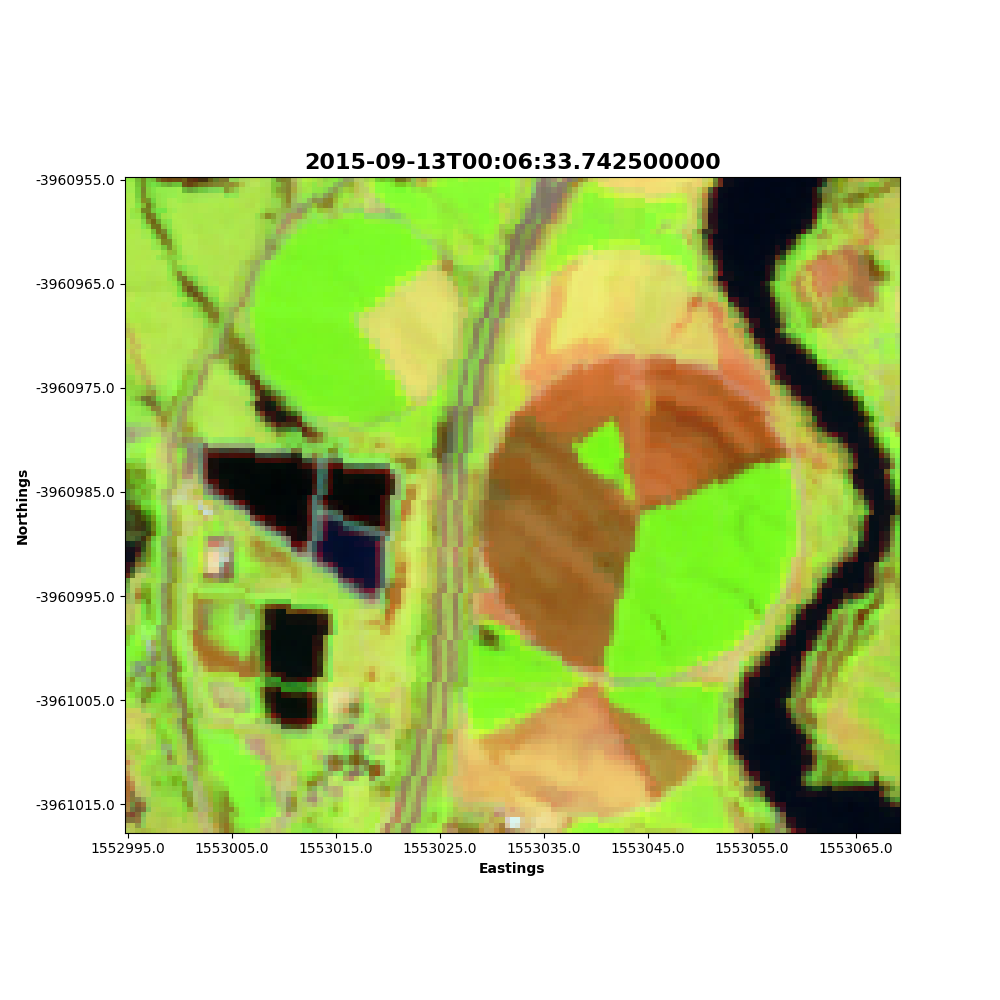

HTML(value='Click on the pixel you would like to interrogate')

In [7]:
DEAPlotting.three_band_image(Sentinel2adata, bands = ['swir1', 'nir1', 'green'], time = 1)
fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")
def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = Sentinel2adata.affine * (x, y)
    pixelx = int(image_coords[0])
    pixely = int(image_coords[1])
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Compare Landsat and Sentinel2 for a single pixel

<IPython.core.display.Javascript object>


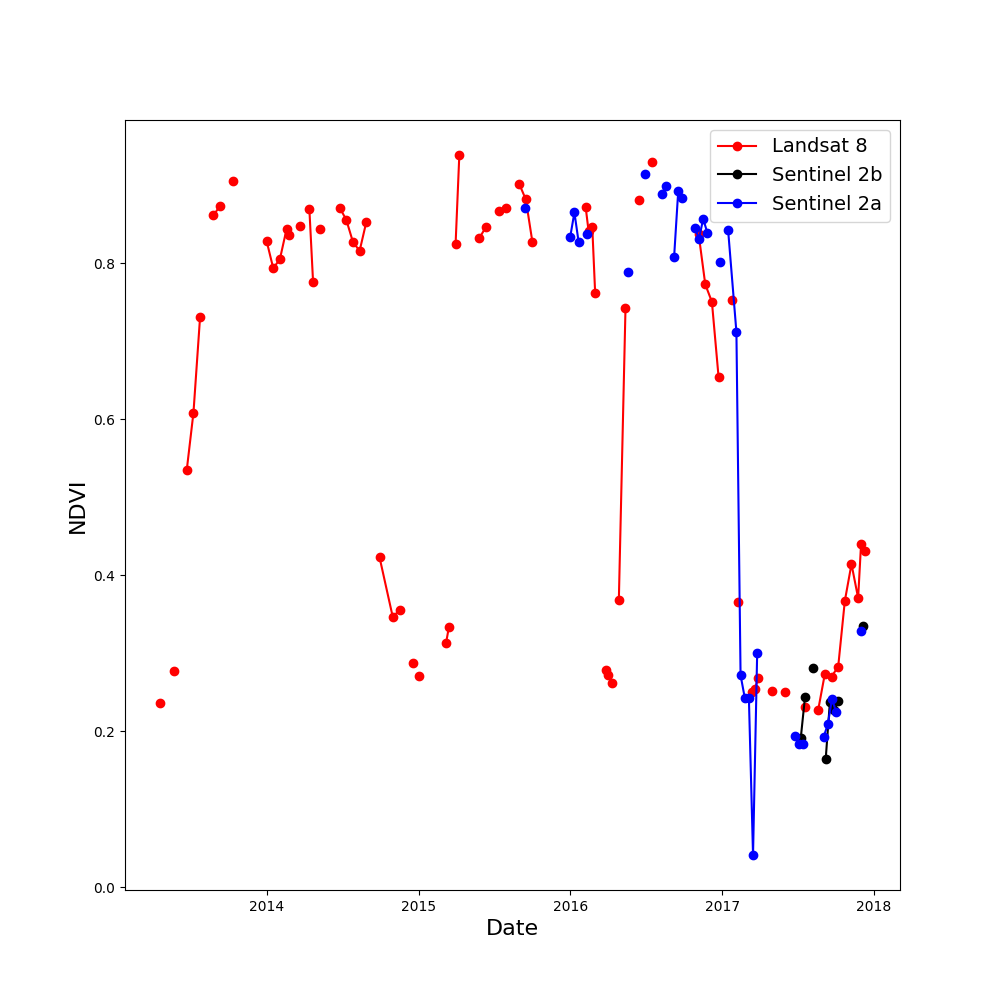

HTML(value='Click on the time you would like to display')

In [20]:
fig = plt.figure(figsize = [10, 10])

plt.plot(Landsatdata.time, LandsatNDVI.sel(y = pixely, x = pixelx, method = 'nearest'), 'ro-')
plt.plot(Sentinel2bdata.time, Sentinel2bNDVI.sel(y = pixely, x = pixelx, method = 'nearest'), 'ko-')
plt.plot(Sentinel2adata.time, Sentinel2aNDVI.sel(y = pixely, x = pixelx, method = 'nearest'), 'bo-')
plt.legend(labels = ['Landsat 8', 'Sentinel 2b', 'Sentinel 2a', ], fontsize = 14)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('NDVI', fontsize = 16)

w = widgets.HTML("Click on the time you would like to display")
def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Select a time from the time series to show the satellite imagery for that sensor

In [9]:
WhichSensor = Sentinel2adata

### Convert the selected time to a time stamp we can use to extract the correct scene

In [21]:
time_slice = matplotlib.dates.num2date(timeOfInterest).date() #Convert clicked int to datetime format
time_slice=str(time_slice) #Convert clicked value to str
time_slice= pd.to_datetime(time_slice, format='%Y-%m-%d') #Convert clicked value to correct datetime format
time_slice

Timestamp('2016-08-19 00:00:00')

## Plot the scene that matches the selected time and sensor

In thsi example, we selected a 'wet' pixel. Let's see if it actually is wet...

<IPython.core.display.Javascript object>


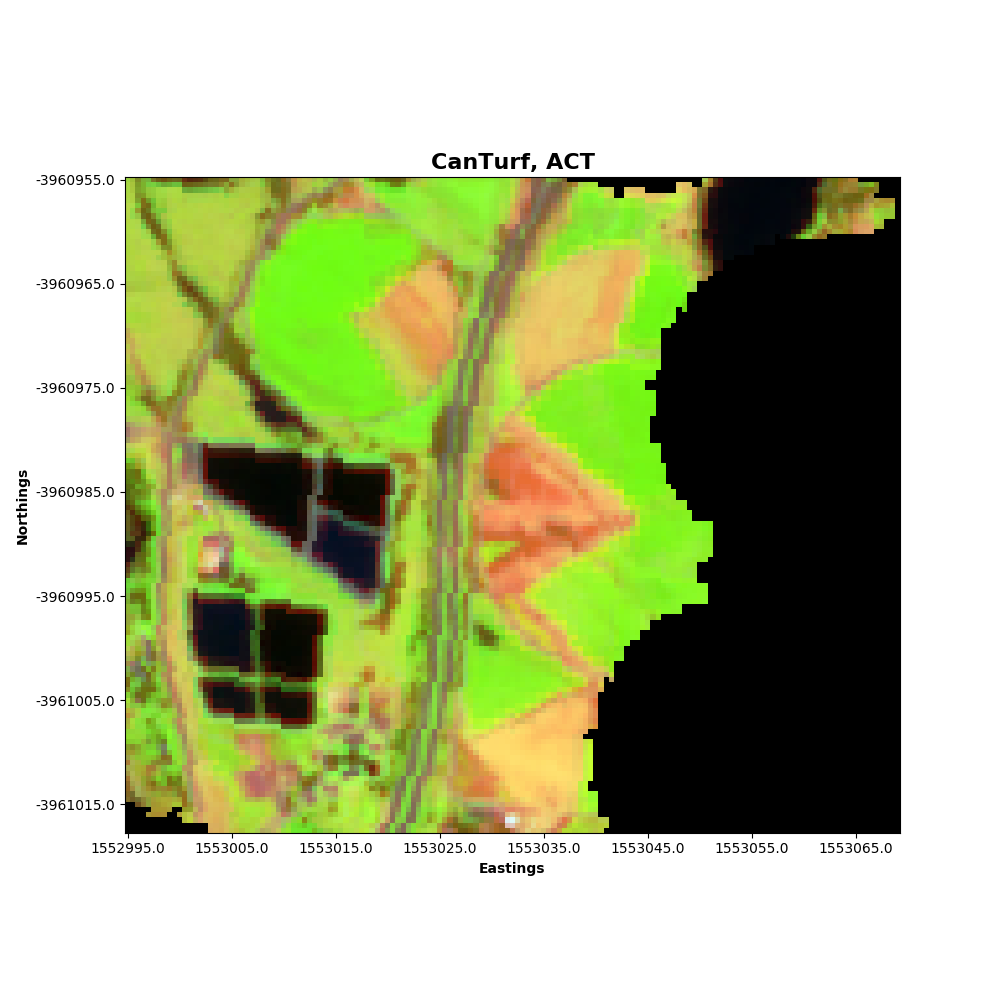

In [22]:
DEAPlotting.three_band_image(WhichSensor.sel(time = time_slice, method = 'nearest'), bands = ['swir1', 'nir1', 'green'],
                            title = 'CanTurf, ACT')